# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
path = Path('../../data/midi/v16/sf4/piano_duet')

## Single Stream Encoding

In [9]:
config = v15m_config(vocab); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.2,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312}

## Fastai Learner

In [10]:
# data = load_music_data(path, cache_name='tmp/sample', vocab=vocab, **config)
data = load_music_data(path/'tmp/sample', cache_name='', vocab=vocab, **config)

In [11]:
saved_models = get_files(path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/4_ep90_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/4_ep90.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hq/3_ep30_full.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hook_c/1_ep60.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/hook_c/1_ep60_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/1_ep30_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/3_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/5_ep30_reencode_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/1_ep30.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/2_ep30_full_best.pth'),
 PosixPath('../../data/midi/v16/sf4/piano_duet/models/unilm/lq/3_ep30_full.pth'),

In [18]:
load_path = saved_models[-5]; load_path

PosixPath('../../data/midi/v16/sf4/piano_duet/models/txl/hook_c/3_ep50_reencode_best.pth')

In [19]:
learn = load_music_learner(data, config.copy(), load_path)

In [20]:
# learn = music_model_learner(data, config.copy())

## Debugging prediction values

In [21]:
# xb,yb = data.one_batch(cpu=False)

# learn.pred_batch(batch=(xb,yb))

## Prediction

In [22]:
data_dir = 'data/midi/v16/'
source_dir = 'piano_duet'
file_path = Path('../../')

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

In [23]:
# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('thousand-miles')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
180100,chorus,C,https://www.hooktheory.com/theorytab/view/vane...,midi_sources/hooktheory/pianoroll/v/vanessa-ca...,vanessa-carlton,f2cf91367abecbb3dff2810bdfcaf213,sf4/piano_duet/hooktheory/pianoroll/v/vanessa-...,0.0,a-thousand-miles,A Thousand Miles,"intro,verse-and-pre-chorus,chorus","Pop,Singer-Songwriter",NaN,hooktheory_c,1.0,4.0,96.0
180101,verse-and-pre-chorus,C,https://www.hooktheory.com/theorytab/view/vane...,midi_sources/hooktheory/pianoroll/v/vanessa-ca...,vanessa-carlton,58890c433f173ba77220274017b8af92,sf4/piano_duet/hooktheory/pianoroll/v/vanessa-...,0.0,a-thousand-miles,A thousand miles verse and prechorus,"intro,verse-and-pre-chorus,chorus","Pop,Singer-Songwriter",NaN,hooktheory_c,1.0,4.0,96.0
180102,intro,C,https://www.hooktheory.com/theorytab/view/vane...,midi_sources/hooktheory/pianoroll/v/vanessa-ca...,vanessa-carlton,35b918db64b172243492a5a6722a3f9f,sf4/piano_duet/hooktheory/pianoroll/v/vanessa-...,0.0,a-thousand-miles,A Thousand Miles,"intro,verse-and-pre-chorus,chorus","Pop,Singer-Songwriter",NaN,hooktheory_c,1.0,4.0,92.0


In [24]:
idx = 2
file = file_path/data_dir/results.numpy.values[idx]; 
# orig = file_path/data_dir/results.mxl.values[idx];
orig = file_path/data_dir/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v16/sf4/piano_duet/hooktheory/pianoroll/v/vanessa-carlton/a-thousand-miles/intro_key_cmajor.npy'),
 PosixPath('../../data/midi/v16/midi_sources/hooktheory/pianoroll/v/vanessa-carlton/a-thousand-miles/intro_key_cmajor.mid'))

In [25]:
seed_len = 120
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

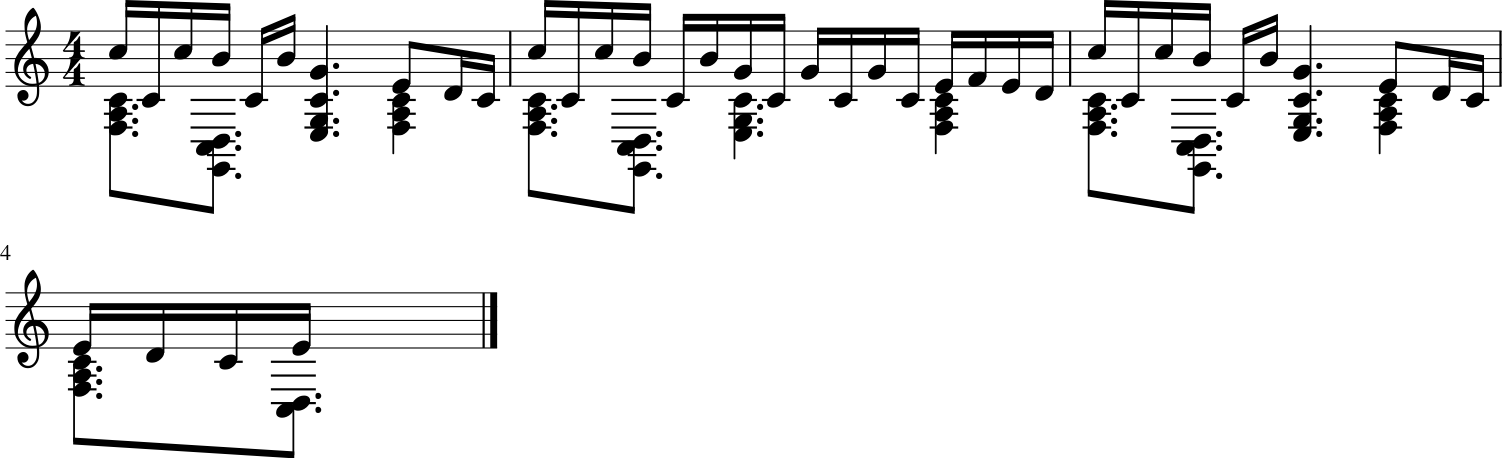

In [26]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

In [27]:
vocab.textify(xb[0])

'xxbos xxpad n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d6 n60 d6 n55 d6 n52 d6 xxsep d6 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n62 d1 xxsep d1 n60 d1 xxsep d1 n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d1 n60 d6 n55 d6 n52 d6 xxsep d1 n60 d1 xxsep d1 n67 d1 xxsep d1 n60 d1 xxsep d1 n67 d1 xxsep d1 n60 d1 xxsep d1 n64 d1 n60 d4 n57 d4 n53 d4 xxsep d1 n65 d1 xxsep d1 n64 d1 xxsep d1 n62 d1 xxsep d1 n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d6 n60 d6 n55 d6 n52 d6 xxsep d6 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n62 d1 xxsep d1 n60 d1 xxsep d1 n64 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n62 d1 xxsep d1 n60 d1 xxsep d1 n64 d1 n50 d3 n48 d3'

In [28]:
seed_stream.show('midi')

In [29]:
out_s, seed_s = learn.predict_topk(xb, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

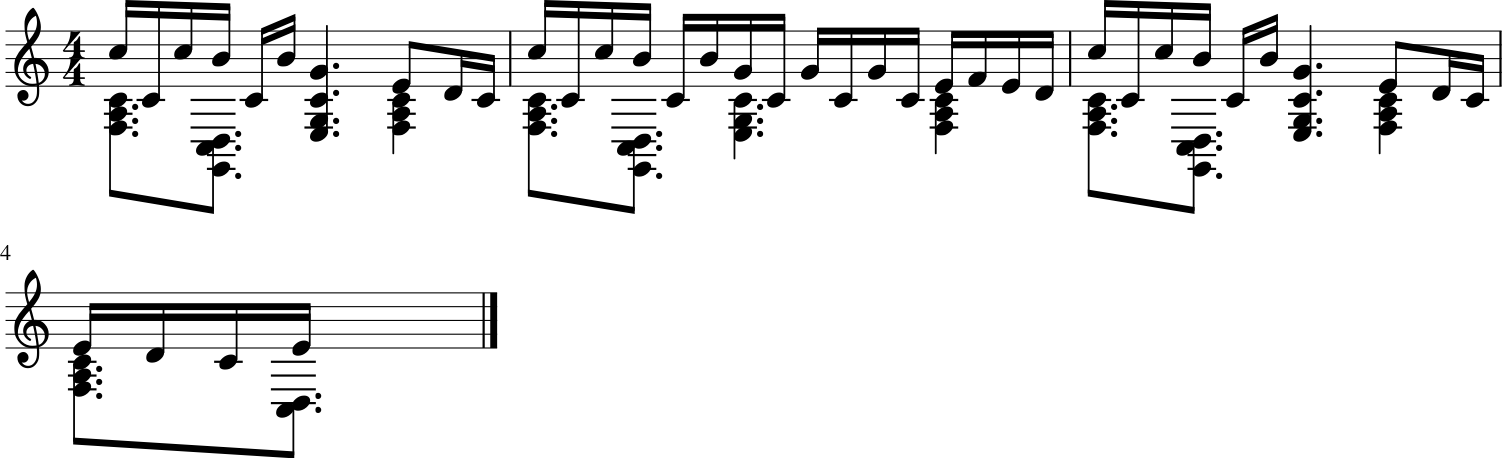

In [30]:
stream = npenc2stream(to_double_stream(seed_s))
stream.show()

In [31]:
vocab.textify(out_s)

'n43 d3 xxsep d1 n62 d1 xxsep d1 n60 d1 xxsep d1 n67 d6 n60 d6 n55 d6 n52 d6 xxsep d6 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n64 d1 xxsep d1 n67 d1 xxsep d1 n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d6 n60 d6 n55 d6 n52 d6 xxsep d6 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n62 d1 xxsep d1 n60 d1 xxsep d1 n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d1 n60 d6 n55 d6 n52 d6 xxsep d1 n60 d1 n41 d1 xxsep d1 n43 d1 xxsep d1 n43 d1 xxsep d1 n43 d1 xxsep d1 n43 d1 xxsep d1 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n62 d1 xxsep d1 n60 d1 xxsep d1 n72 d1 n60 d3 n57 d3 n53 d3 xxsep d1 n60 d1 xxsep d1 n72 d1 xxsep d1 n71 d1 n50 d3 n48 d3 n43 d3 xxsep d1 n60 d1 xxsep d1 n71 d1 xxsep d1 n67 d6 n60 d6 n55 d6 n52 d6 xxsep d6 n64 d2 n60 d4 n57 d4 n53 d4 xxsep d2 n62 d1 xxsep d1 n60 d1 xxsep d1 n64 d1 n60 d3 n57 d3 n53 d

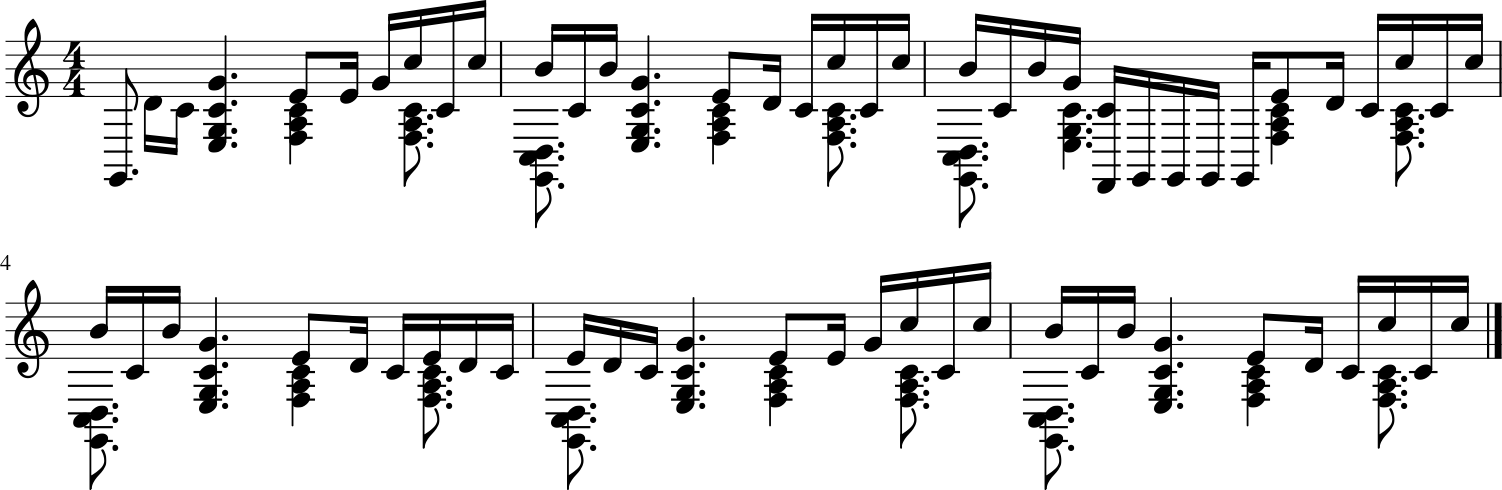

In [32]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [33]:
stream.show('midi')

In [34]:
stream = npenc2stream(to_double_stream(np.concatenate((seed_s, out_s))))
stream.show('midi')

## Prediction

In [69]:
x,y = data.one_batch(cpu=False)

In [70]:
out,seed = learn.predict(x, n_words=100)

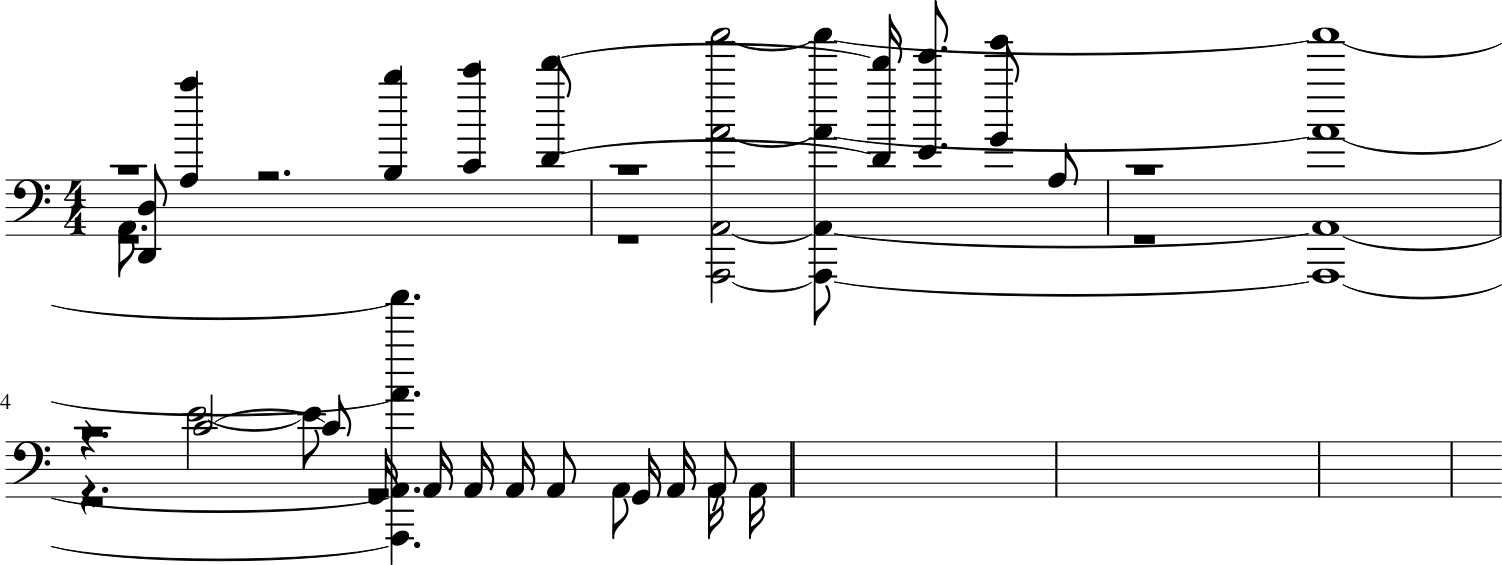

In [72]:
stream = npenc2stream(to_double_stream(seed))
stream.show()

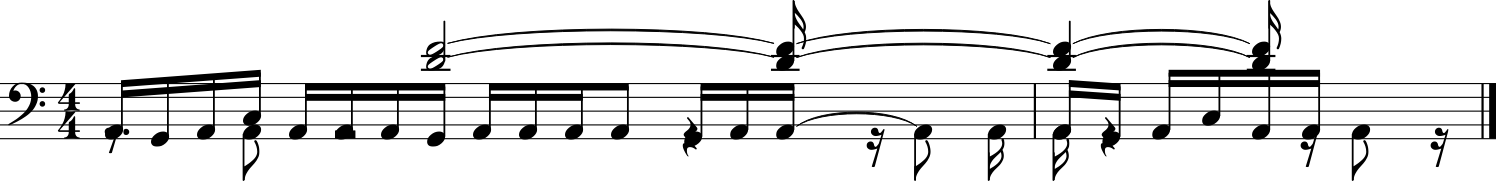

In [74]:
stream = npenc2stream(to_double_stream(out))
stream.show()

In [ ]:
stream.show('midi')

### From song

In [37]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [38]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-cho

In [39]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/chorus_key_original.npy')

In [40]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [41]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [43]:
out, seed = learn.predict(xb, n_words=340, temperature=.7, min_p=0.01)

ValueError: too many values to unpack (expected 2)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


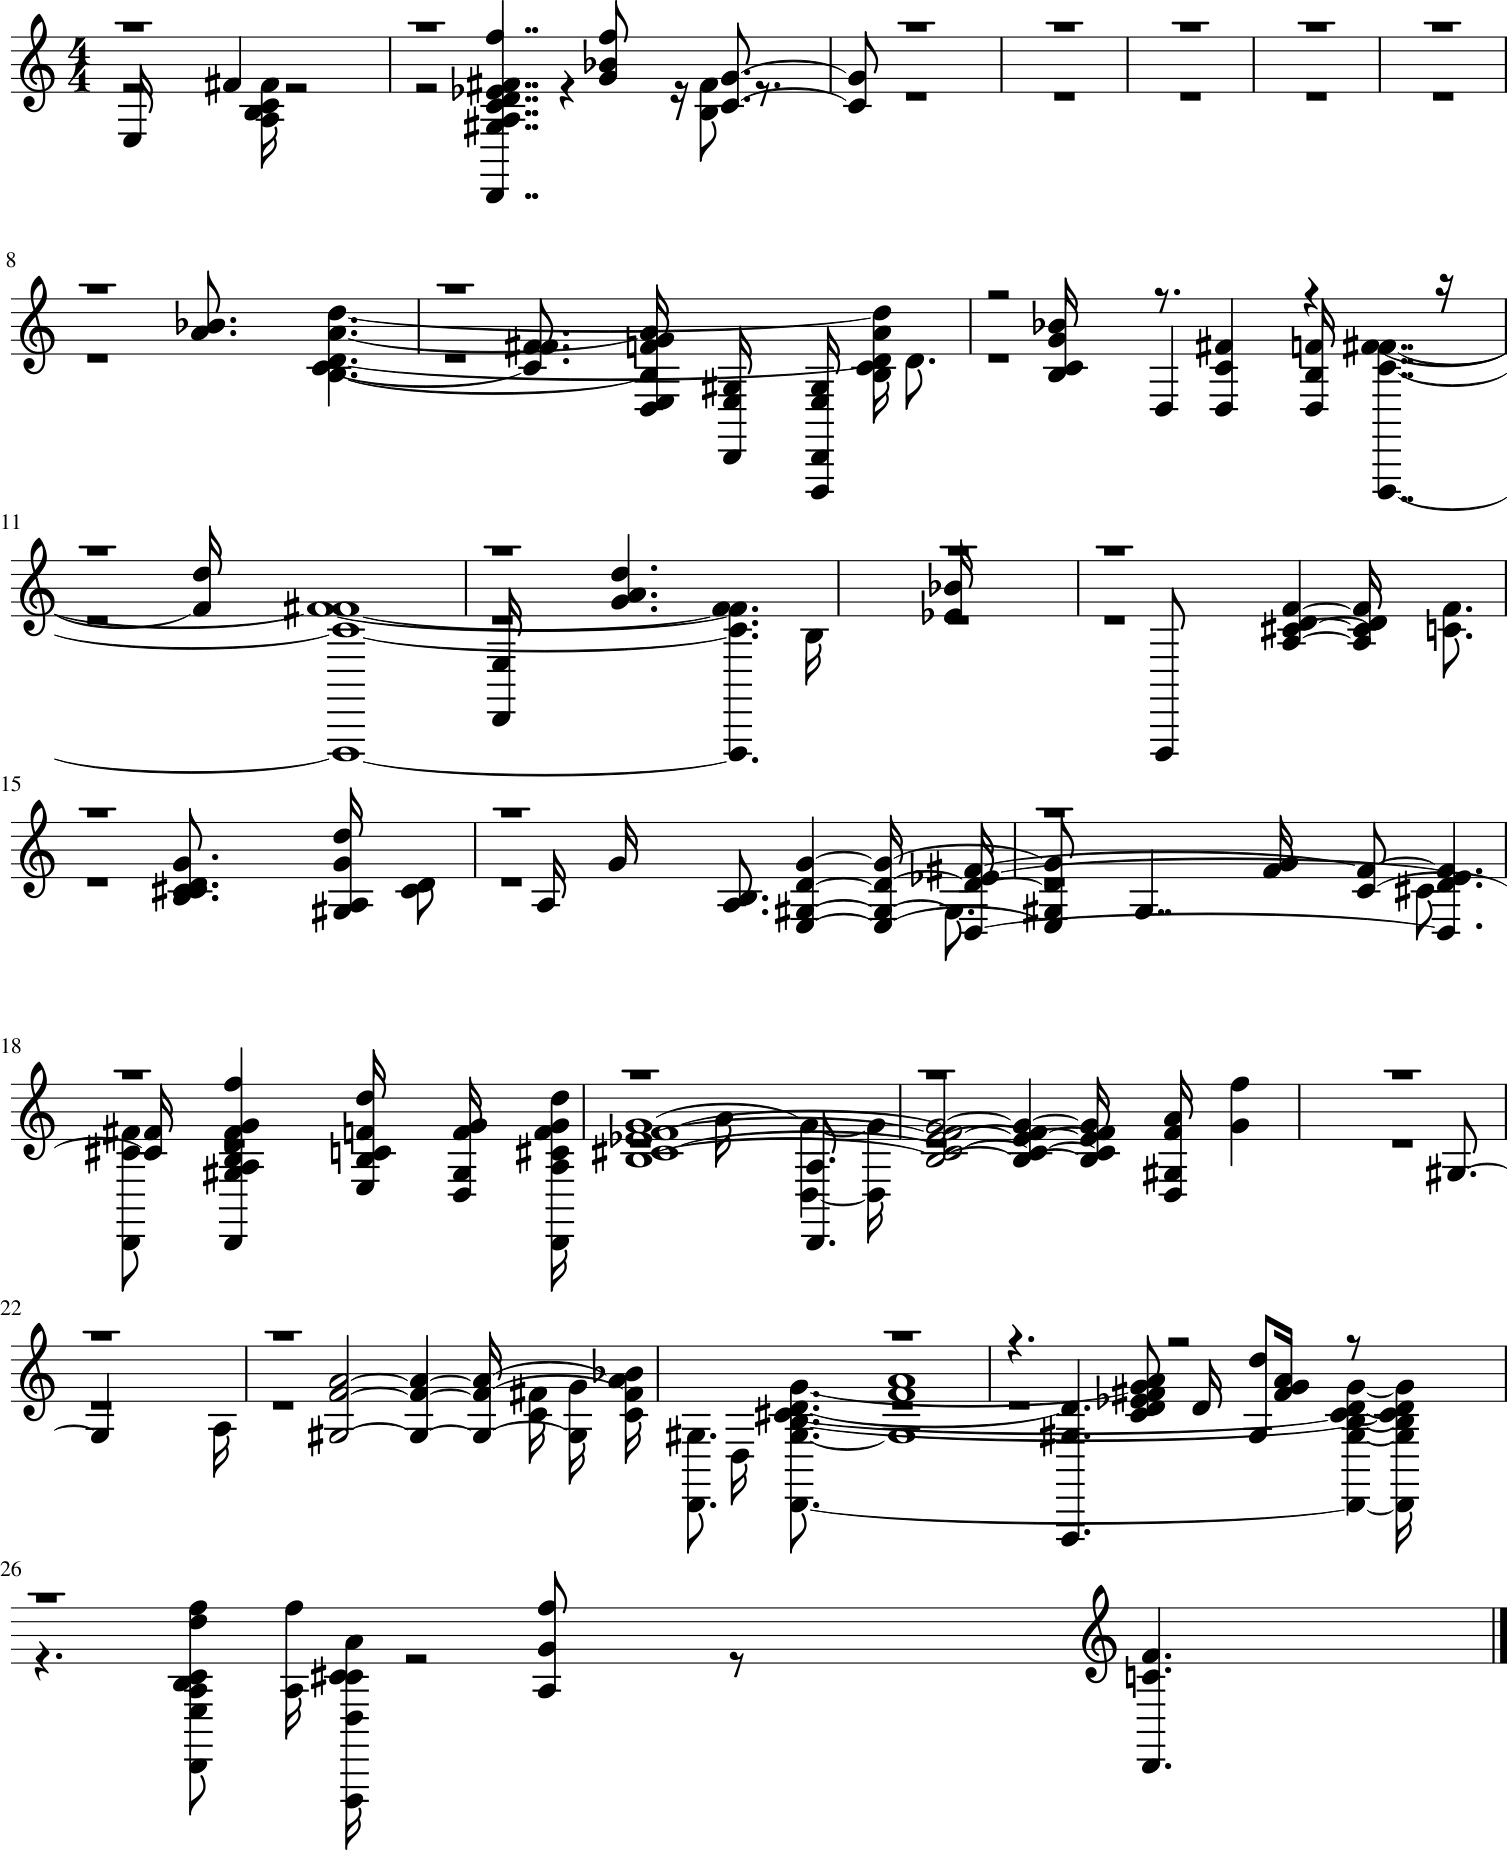

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

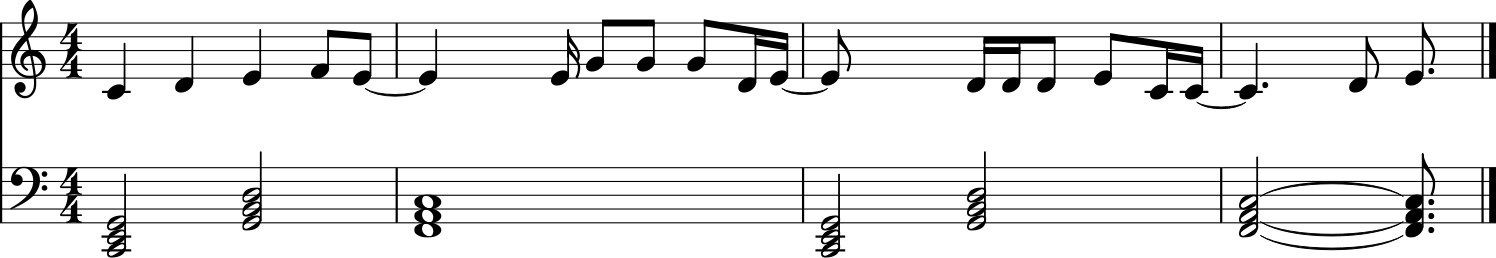

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')